In [59]:
import django, sys, os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *
from scipy.sparse import *
from scipy.spatial import ConvexHull

import matplotlib
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 

run_id = 662

stat = RunStats.objects.get(pk=run_id)
if stat.method=="DT":
    dto = DocDynamicTopic.objects
else:
    dto = DocTopic.objects


In [26]:
db_matrix = DocDynamicTopic.objects.filter(run_id=run_id,score__gt=0.01)
docs = set(db_matrix.values_list('doc__id',flat=True))

len(docs)

289061

In [27]:
s_docs = random.sample(docs,20000)

In [28]:
column = 'term_id'
column = 'doc_id'

stat = RunStats.objects.get(pk=run_id)

db_matrix = DocDynamicTopic.objects.filter(
    run_id=run_id,
    score__gt=0.01,
    doc__id__in=s_docs
)





vs = list(db_matrix.values('score',column,'topic_id'))

c_ind = np.array(db_matrix.values_list(column,flat=True).order_by(column).distinct())
r_ind = np.array(db_matrix.values_list('topic_id',flat=True).order_by('topic_id').distinct())

d = [x['score'] for x in vs]


c = [int(np.where(c_ind==x[column])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic_id'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

m = csr_matrix((d,(c,r)),shape=(len(c_ind),len(r_ind)))

print(db_matrix.count())

155542


In [29]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
tsne_results = tsne.fit_transform(m.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20000 samples in 1.207s...
[t-SNE] Computed neighbors for 20000 samples in 110.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for 

## Urban (blue), and Buildings (red) are close together 

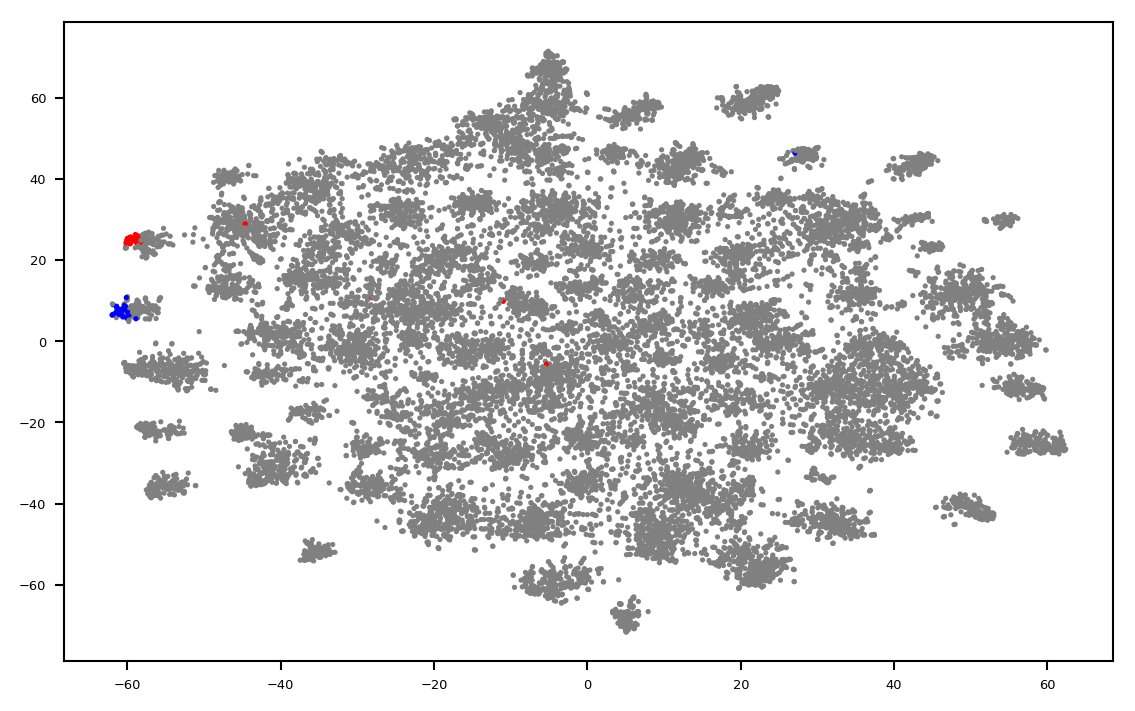

In [30]:


cmap = {
    1: "#66c2a5",
    2: "#fc8d62",
    3: "#8da0cb"
}

cs = []
sizes = []
xs = []
ys = []


fig = plt.figure(dpi=188)

build = list(DocTopic.objects.filter(
    topic__id=125029,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))

urban = list(DocTopic.objects.filter(
    topic__id=124998,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))

ubs = list(DocTopic.objects.filter(
    topic__id=124998,doc__id__in=s_docs
).order_by('-score')[:50].values_list('doc__id',flat=True))


#for i,t in enumerate(Doc.objects.filter(id__in=c_ind)):
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    #if x > -7 and x < -5 and y > 4 and y < 6:
    if x>-10000000:
        #if hasattr(t,'wosarticle'):
        #    if t.wosarticle.tc is not None:
        #        if t.wosarticle.tc > 5000:
        #            plt.text(x,y,t.title,fontsize=5)
        #plt.text(x,y,t.title,fontsize=7)
        if did in build:
            cs.append("red")
        elif did in urban:
            cs.append("blue")
        else:
            cs.append("grey")
        #cs.append(cmap[t.primary_wg])
        #sizes.append(t.score)
        xs.append(x)
        ys.append(y)

plt.scatter(
    xs,
    ys,
    s=1,
    #s=sizes,
    c=cs,
)
plt.show()

## Clusters are mixtures of disciplines, but disciplines congregate in broad areas of the graph

This indicates that the distance **between** clusters is also telling us something interesting

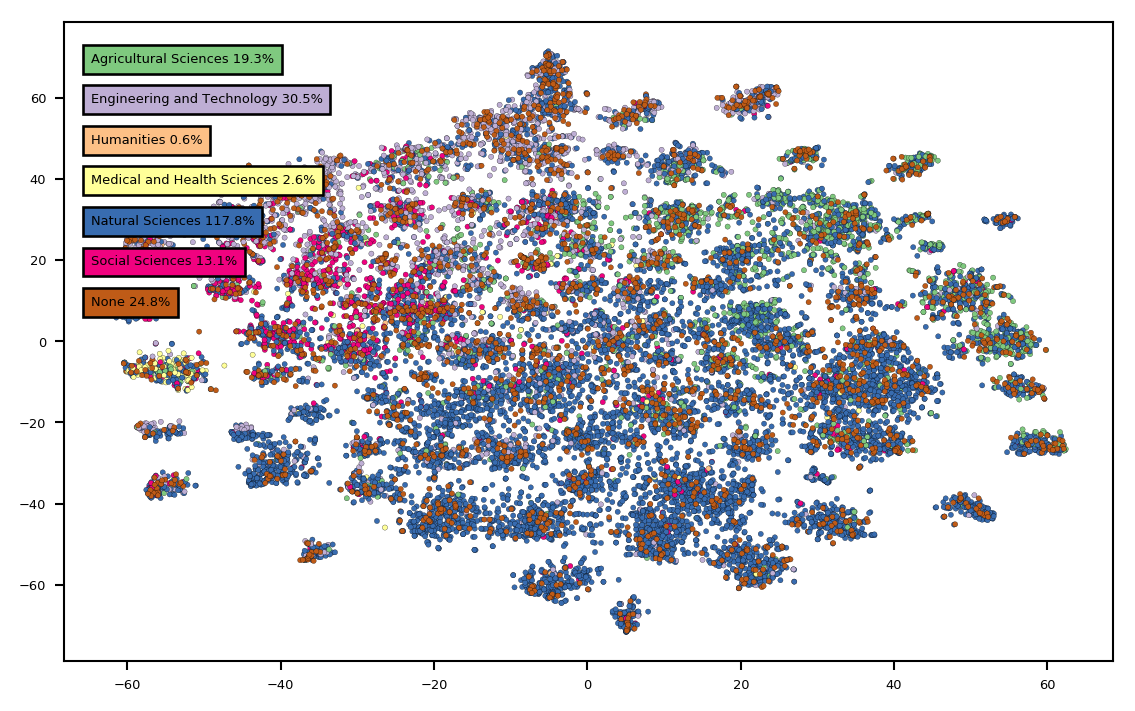

In [34]:
cs = []
sizes = []
xs = []
ys = []


fig = plt.figure(dpi=188)

colors = ['#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae']
colors = ['#b3e2cd','#fdcdac','#cbd5e8','#f4cae4','#e6f5c9','#fff2ae','#f1e2cc']
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]


#for i,t in enumerate(Doc.objects.filter(id__in=c_ind)):
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "grey"
    for c in oecd_cats:
        if did in c['docs']:
            col = c['color']
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)

l = plt.xlim()[0]
t = plt.ylim()[1]

for i,c in enumerate(oecd_cats):
    plt.text(
        l*0.95,
        t-10-i*10,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

## Not many documents in the sample were cited by IPCC, but they reinforce the story suggested by the graph above

(note that this sample will contain a large proportion of documents written since the last report)

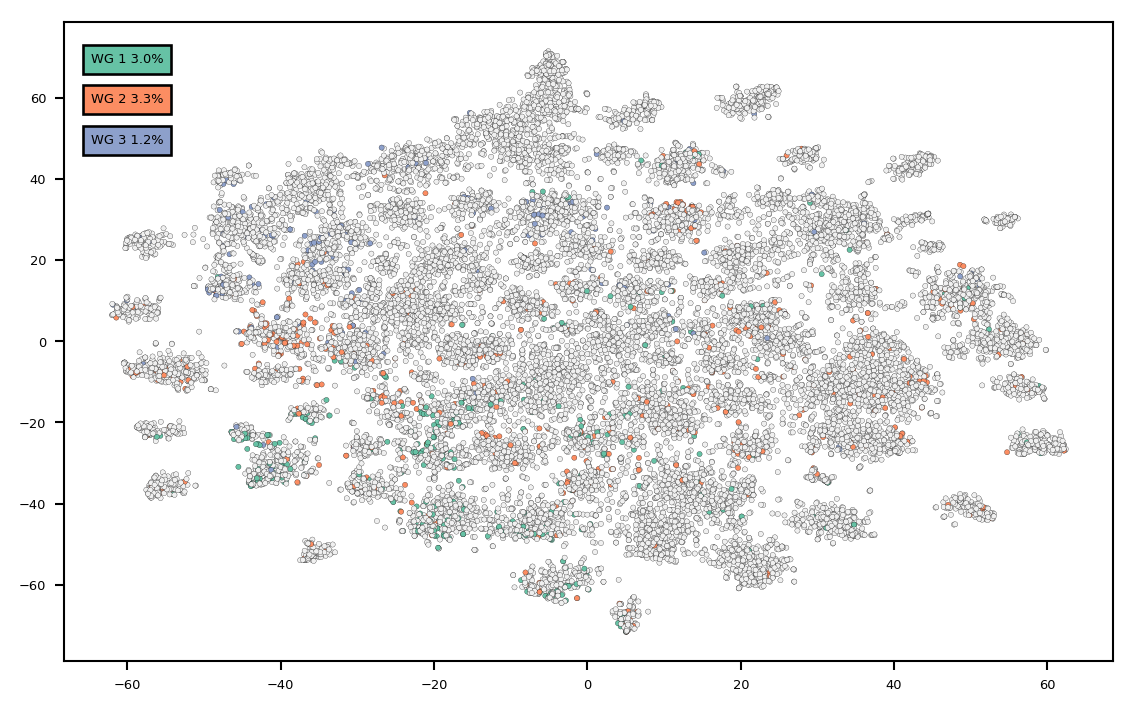

In [37]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=s_docs,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

ldocs = 0
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "#F0F0F0"
    for c in wgs:
        if did in c['docs']:
            col = c['color']
    cs.append(col)
    xs.append(x)
    ys.append(y)
    ldocs+=1
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)

l = plt.xlim()[0]
t = plt.ylim()[1]
for i,c in enumerate(wgs):
    plt.text(
        l*0.95,
        t-10-i*10,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/ldocs),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

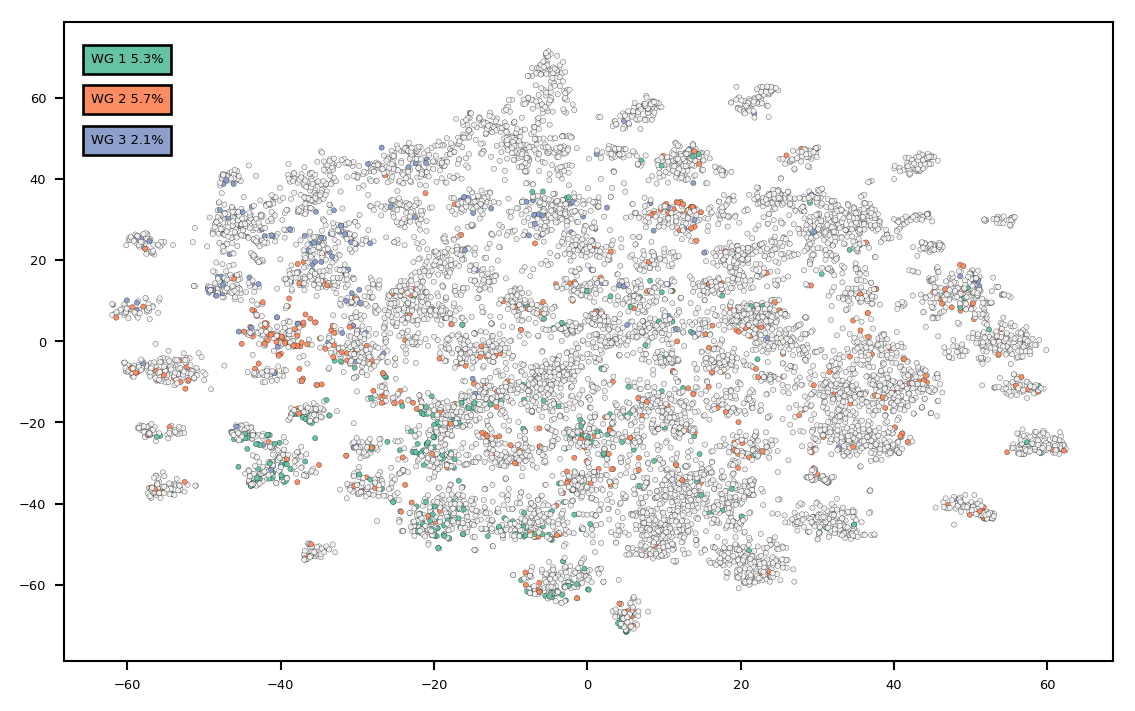

In [36]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=s_docs,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]

post_ar5 = list(Doc.objects.filter(
        id__in=s_docs,PY__gt=2013
).values_list('id',flat=True))

ldocs = 0
for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = "#F0F0F0"
    for c in wgs:
        if did in c['docs']:
            col = c['color']
    if did not in post_ar5:
        cs.append(col)
        xs.append(x)
        ys.append(y)
        ldocs+=1

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)
l = plt.xlim()[0]
t = plt.ylim()[1]
for i,c in enumerate(wgs):
    plt.text(
        l*0.95,
        t-10-i*10,
        "WG {} {:.1%}".format(c['wg'],len(c['docs'])/ldocs),
        fontsize=5,
        bbox={
            'facecolor': c['color'],
            'pad': 3
        }
    )
plt.show()

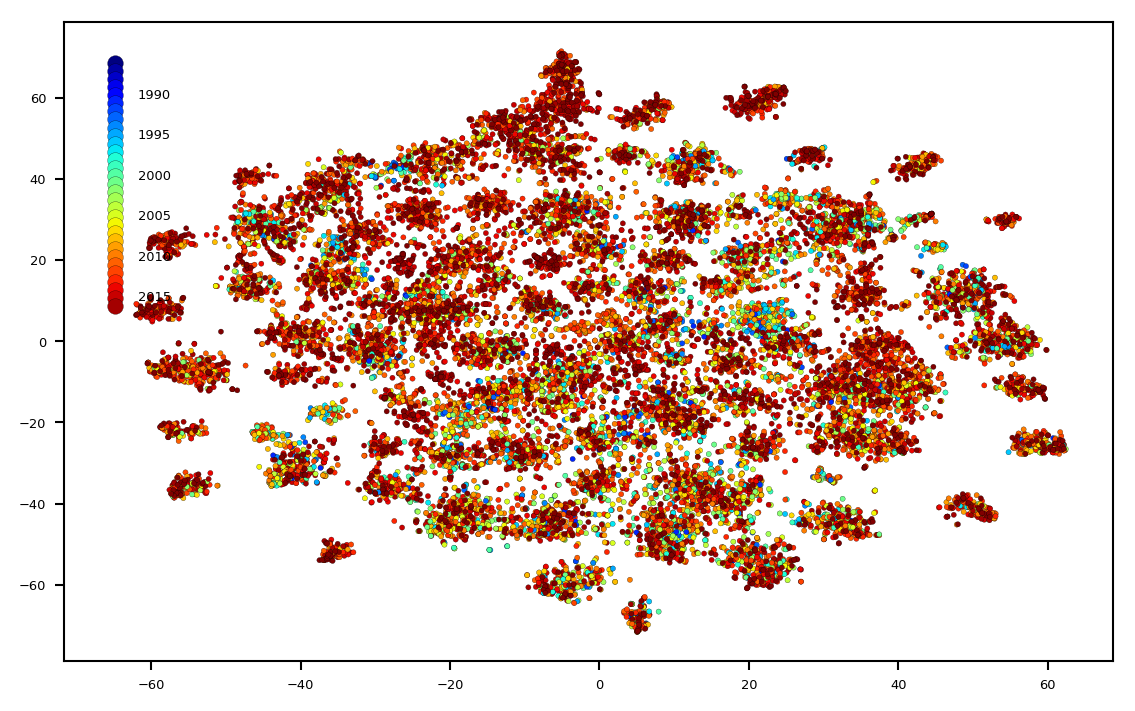

In [40]:
cs = []
sizes = []
xs = []
ys = []
fig = plt.figure(dpi=188)

years = list(Doc.objects.filter(
    id__in=s_docs
).values_list('PY',flat=True))

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(years), vmax=max(years))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

scalarMap.to_rgba(1995)

for i,did in enumerate(c_ind):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    col = scalarMap.to_rgba(years[i])
    cs.append(col)
    xs.append(x)
    ys.append(y)
        

plt.scatter(
    xs,
    ys,
    s=4,
    #s=sizes,
    linewidth=0.1,
    c=cs,
    edgecolor='k'
)

i = 0

l = plt.xlim()[0]
t = plt.ylim()[1]

for y in range(scalarMap.get_clim()[0],scalarMap.get_clim()[1]):
    plt.scatter(
        l*0.95,
        t-10-i*2,
        c=scalarMap.to_rgba(y),
        linewidth=0.1,
        edgecolor='k'
        
    )
    if y % 5 == 0:
        plt.text(
            l*0.95+3,
            t-10-i*2,
            y,
            fontsize=5,
            va="center",
            ha="left"
        )
    i+=1


plt.show()


In [50]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1.5,min_samples=20).fit(tsne_results)

labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 114


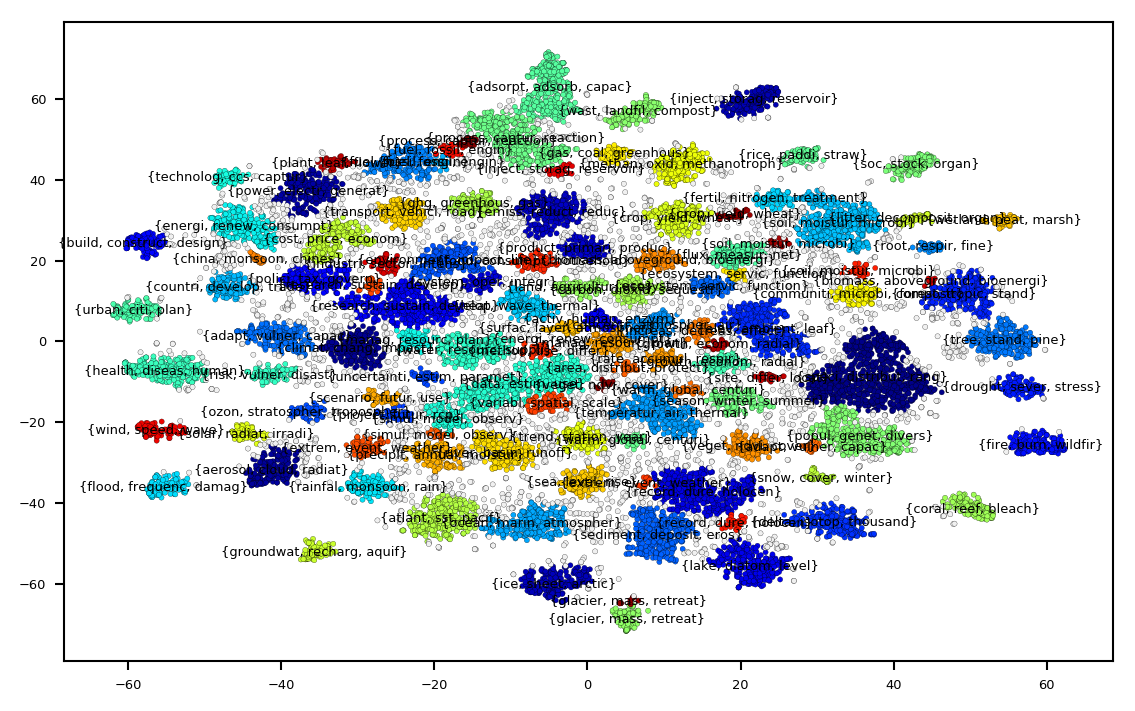

In [51]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for l in set(labels):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        if l==-1:
            cs.append("#F0F0F0")
        else:
            cs.append(scalarMap.to_rgba(l))
        xs.append(x)
        ys.append(y)
        dids.append(c_ind[did[0]])
        
    dts = DocDynamicTopic.objects.filter(
        doc__id__in=dids,
        run_id=run_id
    ).values('topic__title').annotate(
        tscore=Sum('score')
    ).order_by('-tscore')
        
    plt.text(
        np.mean(xs),
        np.mean(ys),
        dts.first()['topic__title'],
        ha="center",
        va="center",
        fontsize=5
    )
        
    plt.scatter(
        xs,
        ys,
        s=4,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )

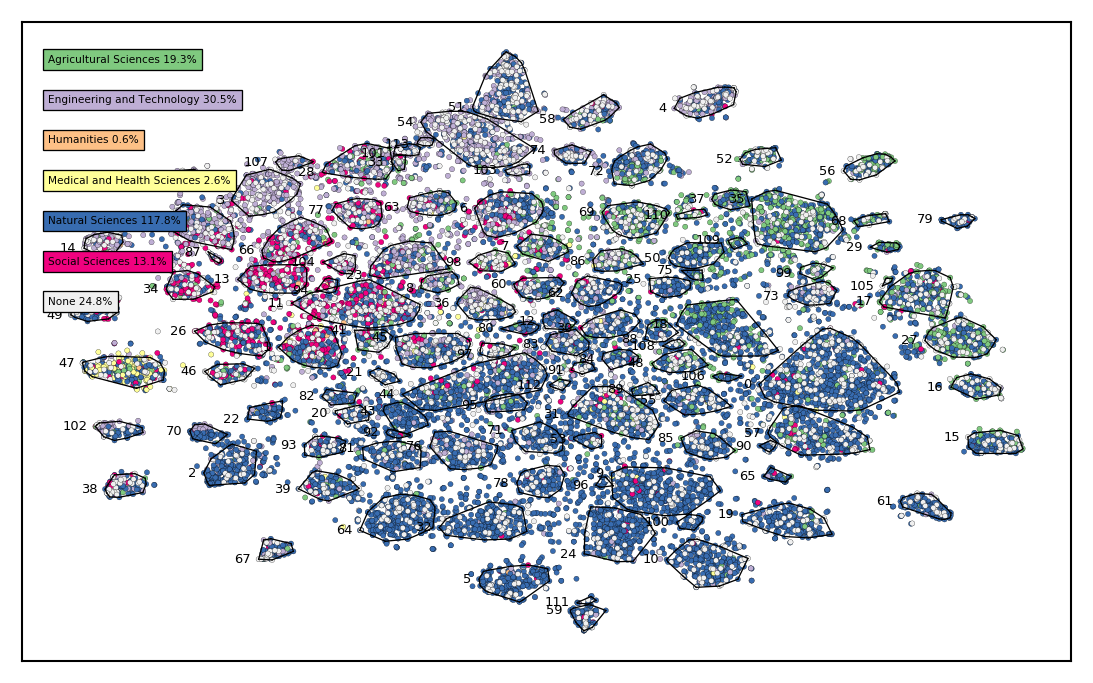

In [55]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

df = pd.DataFrame()

colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "grey"
        for c in oecd_cats:
            if c_ind[did[0]] in c['docs']:
                col = c['color']
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(c_ind[did[0]])
        
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=4,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )
l = plt.xlim()[0]
t = plt.ylim()[1]
for i,c in enumerate(oecd_cats):
    plt.text(
        l*0.95,
        t-10-i*10,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)

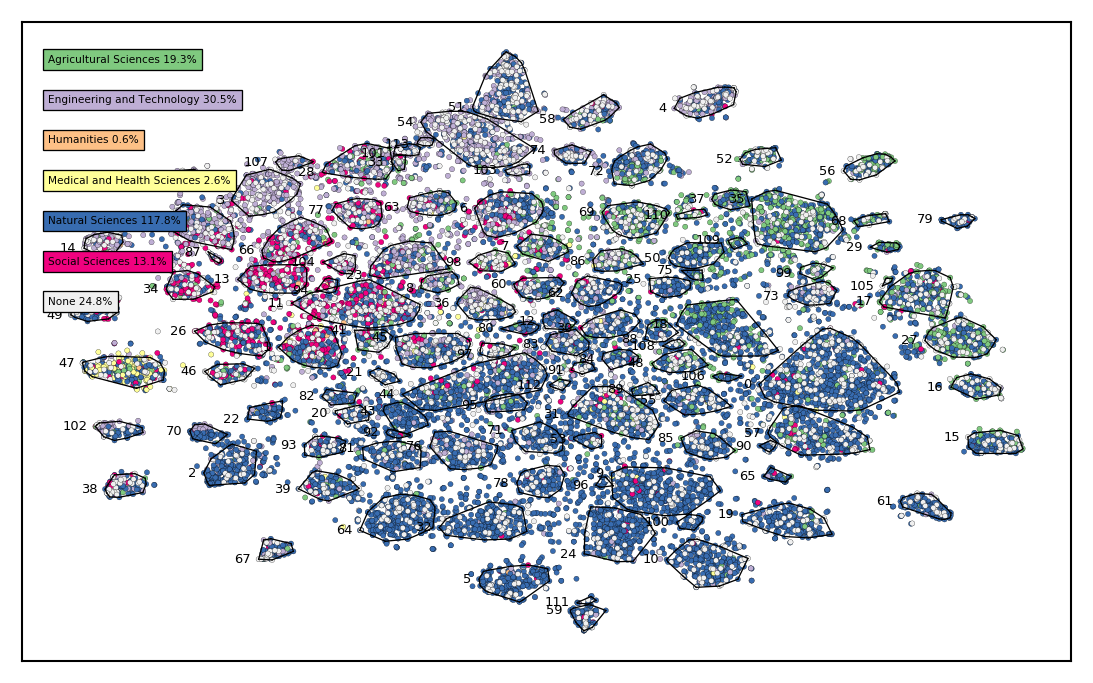

In [83]:
label_set = list(set(labels))

fig = plt.figure(dpi=188)

import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=min(label_set), vmax=max(label_set))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

df = pd.DataFrame()

doc_df = pd.DataFrame()

colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = list(Doc.objects.filter(id__in=s_docs).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=s_docs,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['color'] = colors[i]

for l in list(set(labels)):
    ind = np.argwhere(labels==l)
    cs = []
    sizes = []
    xs = []
    ys = []
    
    dids = []

    for i,did in enumerate(ind):
        x = tsne_results[did[0],0]
        y = tsne_results[did[0],1]
        col = "grey"
        for c in oecd_cats:
            if c_ind[did[0]] in c['docs']:
                col = c['color']
        cs.append(col)
        xs.append(x)
        ys.append(y)
        dids.append(c_ind[did[0]])
        
    cdocs = Doc.objects.filter(id__in=dids).values('title','PY')
    rows = pd.DataFrame.from_dict(list(cdocs))
    rows['cluster'] = l
    doc_df = doc_df.append(rows)
        
    dt = dto.filter(
        doc__id__in=dids,
        run_id=run_id
    ).aggregate(
        tscore=Sum('score')
    )

    dts = dto.filter(
        doc__id__in=dids,
        run_id=run_id
    ).values('topic__title').annotate(
        tscore=Sum('score'),
        tshare = Sum('score')/dt['tscore'],
        #cluster = l
    ).order_by('-tscore')

    rows = pd.DataFrame.from_dict(list(dts))
    rows['cluster'] = l
    df = df.append(rows)
        
    if l !=-1:
        points = np.array([(xs[i],ys[i]) for i,v in enumerate(xs)])
        hull = ConvexHull(points)
        for i, simplex in enumerate(hull.simplices):
            plt.plot(
                points[simplex, 0], 
                points[simplex, 1], 
                'k-',
                linewidth=0.5
            )
            for j in range(len(points[simplex,0])):                
                if i==0 and j==0:
                    px = points[simplex,0][j]
                    py = points[simplex,1][j]
                else:
                    if points[simplex,0][j] < px:
                        px = points[simplex,0][j]
                        py = points[simplex,1][j]                    

        plt.text(
            px-1,
            py,
            l,
            va="center",
            ha="right",
            fontsize=5
        )
        
    plt.scatter(
        xs,
        ys,
        s=4,
        #s=sizes,
        linewidth=0.1,
        c=cs,
        edgecolor='k'
    )
l = plt.xlim()[0]
t = plt.ylim()[1]
for i,c in enumerate(oecd_cats):
    plt.text(
        l*0.95,
        t-10-i*10,
        "{} {:.1%}".format(c['wc__oecd'],len(c['docs'])/10000),
        fontsize=4,
        bbox={
            'facecolor': c['color'],
            'pad': 2,
            'lw': 0.5
        }
    )

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,  
    labelbottom=False,
    left=False,
    labelleft=False
)

In [85]:
cl = 47
df[(df['cluster']==cl) & (df['tshare']>0.01)]

topic__title     tscore    tshare  cluster
0        {health, diseas, human}  19.462693  0.366315       47
1         {risk, vulner, disast}   2.961528  0.055740       47
2   {research, sustain, develop}   2.002329  0.037687       47
3        {climat, chang, impact}   1.999593  0.037635       47
4        {chang, respons, shift}   1.516400  0.028541       47
5         {popul, genet, divers}   1.287356  0.024230       47
6     {temperatur, air, thermal}   1.074964  0.020232       47
7         {adapt, vulner, capac}   0.967820  0.018216       47
8    {environment, impact, life}   0.924892  0.017408       47
9    {food, consumpt, household}   0.910130  0.017130       47
10     {countri, develop, trade}   0.812196  0.015287       47
11     {variabl, spatial, scale}   0.799022  0.015039       47
12         {model, predict, use}   0.738376  0.013897       47
13           {urban, citi, plan}   0.704541  0.013260       47
14      {speci, distribut, rang}   0.668677  0.012585       47
15      {extrem, event, weather}   0.641924  0.012082       47
16            {data, estim, use}   0.629551  0.011849       47
17       {warm, global, centuri}   0.624894  0.011761       47
18        {region, local, scale}   0.591257  0.011128       47
19         {polici, tax, govern}   0.566720  0.010666       47
20    {increas, decreas, effect}   0.560310  0.010546       47
21      {rainfal, monsoon, rain}   0.553801  0.010423       47
22        {system, oper, integr}   0.548520  0.010324       47
23    {concentr, atmospher, air}   0.535883  0.010086       47

In [87]:
doc_df[doc_df['cluster']==cl].head()

PY                                              title  cluster
0  2010  Arthropod borne diseases in Italy: from a negl...       47
1  2010  Do the Health Benefits of Cycling Outweigh the...       47
2  2016             Climate Change, Conflict, and Children       47
3  2016  Rift Valley fever transmission dynamics descri...       47
4  2006  Climate change and human health: present and f...       47

In [241]:
np.save('../data/labels.npy',labels)
np.save('../data/c_ind.npy',c_ind)
np.save('../data/tsne_results.npy',tsne_results)
np.save('../data/s_docs.npy',s_docs)